# Project Part b)

In [1]:
from fenics import *
from dolfin import *
from mshr import *

import matplotlib
#%matplotlib qt
#%matplotlib widget
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import scipy.sparse.linalg as splinalg

from mpl_toolkits.mplot3d import Axes3D

# Problem B.1
The two dimensional stationary problem:
\begin{align}
- \Delta u(x) &= f(x), \qquad x\in \mathscr{B} \\
u(x) &= u_{exact}(x), \quad x\in \partial \mathscr{B}
\end{align}

In which $f(x) = 8 \pi^2sin(2\pi x_1)sin(2*\pi x_2)$ and $u_{exact}(x) = sin(2\pi x_1)sin(2\pi x_2)$. 

## The Galerkin finite element method

Multiply both sizes with a test function $v \in V_0$, $V_0 = \{v \in V, v|_{\partial \mathscr{B}} = 0\}$ and integrate to obtain the weak form:  
\begin{align}
\int_\mathscr{B} fvdx 
&= - \int_\mathscr{B} \Delta u v dx \\
&= \int_\mathscr{B} \nabla u \nabla v dx - \int_\mathscr{B} n\cdot \nabla u v dx \\
&= \int_\mathscr{B} \nabla u \nabla v dx
\end{align}

We need to find $u \in V_g$, $V_g = \{v \in V, V|_{\partial \mathscr{B}} = g\}$, s.t the weak form is satisfied for $\forall v \in V_0$.

In the finite element function space, we need to find $u_h \in V_{h,g}$, $V_{h,g} = \{v \in V_h, V|_{\partial \mathscr{B}} = g\}$, s.t.
$$ \int_\mathscr{B} \nabla u_h \nabla v dx = \int_\mathscr{B} fvdx$$
for $\forall v \in V_{h,0}$, $V_{h,0} = \{v \in V_h, V_h|_{\partial \mathscr{B}} = 0\}$,.

Ansatz: 
$$u_h = \sum_{j=1}^{n_h} \xi_j \phi_j + \sum_{j=n_{h+1}}^{n} \xi_j \phi_j$$
The first term are the interior points and the second term are the points on the boundary, $\xi_j = g_j$, in which $j=n_h+1, ..., n$.

\begin{align}
\int_\mathscr{B} f \phi_i dx
&= \sum_{j=1}^{n_h} \xi_j \int_\mathscr{B} \phi_j'\phi_i' dx + \sum_{j=n_{h+1}}^{n} \xi_j \int_\mathscr{B} \phi_j' \phi_i' dx
\end{align}

Let 
$$A_{ij} =  \int_\mathscr{B} \phi_j'\phi_i' dx$$ 
$$b_i = \int_\mathscr{B} f \phi_i dx$$
$$r_i = \int_\mathscr{B} \phi_j' \phi_i' dx$$

The linear system for $\xi$ becomes:
$$\mathbf{A}\xi = \mathbf{b}-\mathbf{r}$$

In the programming implementation, the boundary condition is imposed strongly by setting the rows in $\mathbf{A}$ for the boundary points to the corresponding rows in the identity matrix and the entries in $\mathbf{b}$ to the Dirichlet boundary values.

## Implementation

In [6]:
# General assemblers and relevant functions
# def gamma(*x):
#     return 0

# def g(*x):
#     return 0

#def assembler(p, e, t, f, gamma=gamma, g=g, alpha=1):
def assembler(p, t, f, alpha=1):
    ''' The inputs corresponds to:
            - alpha * u'' = f
            alpha * u' = 0
    '''
    n_p = np.shape(p)[0]       # number of nodes
    n_t = np.shape(t)[0]       # number of elements
    #n_e = np.shape(e)[0]       # number of boundary edges
    A = sparse.lil_matrix((n_p, n_p))   # allocate stiffnessmatrix
    M = sparse.lil_matrix((n_p, n_p))   # allocate mass matrix
    #R = sparse.lil_matrix((n_p, n_p))   # allocate Robin mass matrix
    b = np.zeros(n_p)          # load vector
    #r = np.zeros(n_p)          # Robin load vector
    
    for K in np.arange(n_t):
        loc2glb = t[K]
        x = p[loc2glb][:,0]   # node x-coordinates
        y = p[loc2glb][:,1]   #      y
        area, bi, ci = HatGradients(x, y)
        AK = alpha * (np.outer(bi,bi) + np.outer(ci,ci)) * area
        bK = np.array([f(x[0], y[0]),
                       f(x[1], y[1]),
                       f(x[2], y[2])])/3*area
        MK = np.array([[2, 1, 1],
                       [1, 2, 1],
                       [1, 1, 2]])/12*area   # element mass matrix
        A[np.ix_(loc2glb, loc2glb)] += AK
        M[np.ix_(loc2glb, loc2glb)] += MK    # Add element masses to M
        b[np.ix_(loc2glb)] += bK
        
    return A, M, b

    
def polyArea(x, y):
    v1 = np.array([x[1]-x[0], y[1]-y[0]])
    v2 = np.array([x[2]-x[0], y[2]-y[0]])
    area = 1/2 * np.linalg.norm(np.cross(v1, v2))
    return area


def HatGradients(x, y):
    ''' Returns the area, b, and c
        Grad(ph_i) = transpose([b_i, c_i])
    '''
    area = polyArea(x, y);
    b = np.array([y[1]-y[2], y[2]-y[0], y[0]-y[1]])/2/area
    c = np.array([x[2]-x[1], x[0]-x[2], x[1]-x[0]])/2/area
    return area, b, c


def energy_norm(u_exact, u, A):
    error = (u_exact - u)[:, np.newaxis]
    return np.sqrt(error.T @ A @ error).ravel()[0]


In [10]:
def f(x, y):    
    '''Force applied at given cooridinates (x,y)'''
    return 8 * np.pi**2 * np.sin(2*np.pi*x) * np.sin(2*np.pi*y)

def u_exact(x, y):
    '''Dirichlet boundary condition'''
    return np.sin(2*pi*x) * np.sin(2*pi*y)

resolutions = [4, 8, 16, 32, 64]    # corresponds to hmax=[1/2, 1/4, 1/8, 1/16, 1/32]
us = {'u4':[], 'u8':[], 'u16':[], 'u32':[], 'u64':[]}   # solution given difference mesh size
xs = {'u4':[], 'u8':[], 'u16':[], 'u32':[], 'u64':[]}    # saving mesh coordinates for the plot
ys = {'u4':[], 'u8':[], 'u16':[], 'u32':[], 'u64':[]}
keys = list(us.keys())
hs = []    # hmax
EnE =[]   # energy norm

for i in range(len(resolutions)):
    # Define domain
    domain = Circle(Point(0.,0.),1.0,60)
    mesh = generate_mesh(domain, resolutions[i], "cgal")

    # Generating p-vertex coordinates, e-edge indices, t-element indices
    p = mesh.coordinates()

    # Constructing the e array. For each edge: (start_index, end_index)
    e_points = BoundaryMesh(mesh, "exterior", True)
    e_indices = e_points.entity_map(0)
    e = e_indices.array()          # first column
    e2 = np.append(e[1:], e[0])    # second column
    e = np.dstack((e, e2)).squeeze()

    t = mesh.cells()

    # Assembling mass matrix and load vector
    #A, _, _, b, _ = assembler(p, e, t, f)
    A, _, b = assembler(p, t, f)

    # Strongly imposed Dirichlet BC
    I = np.eye(len(p))
    A[e[:,0],:] = I[e[:,0],:]
    x = p[:,0]
    y = p[:,1]
    xs[keys[i]] = x.copy()    # saving coordinates to dictionary
    ys[keys[i]] = y.copy()
    b[e[:,0]] = u_exact(x[e[:,0]], y[e[:,0]])

    # Solution to the PDE
    u = splinalg.spsolve(A.tocsr(), b)  
    us[keys[i]] = u.copy()            # saving to the dictionary
    
    # Mesh size and energy norm
    hs.append(mesh.hmax())
    EnE.append(energy_norm(u_exact(x, y), u, A))       # energy_norm(u_exact, u, A)

## Energy norm vs. different mesh sizes and rate of convergence $\gamma$

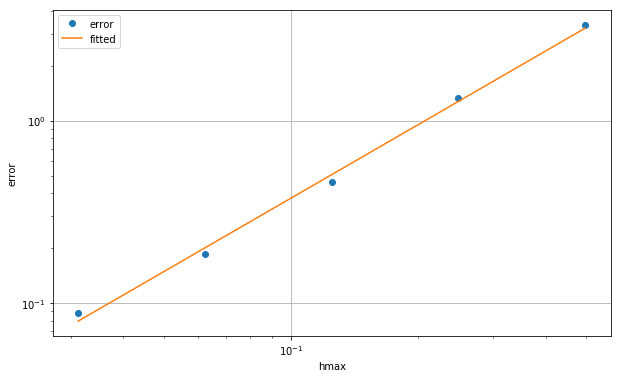

The rate of convergence gamma: 1.3375690223509522


In [11]:
plt.figure(figsize = (10, 6))
plt.loglog(hs, EnE, 'o', label='error')
plt.xlabel('hmax')
plt.ylabel('error')
plt.grid()

# Polyfit shows that the slop is in the magnitude of 1
coef = np.polyfit(np.log(hs), np.log(EnE), deg=1)
Efit = hs ** coef[0] * np.e**coef[1]
plt.loglog(hs, Efit, label='fitted')

plt.savefig('imgs/B1-error.png')
plt.legend()
plt.show()

print('The rate of convergence gamma: ' + str(coef[0]))

### Solution with different mesh sizes

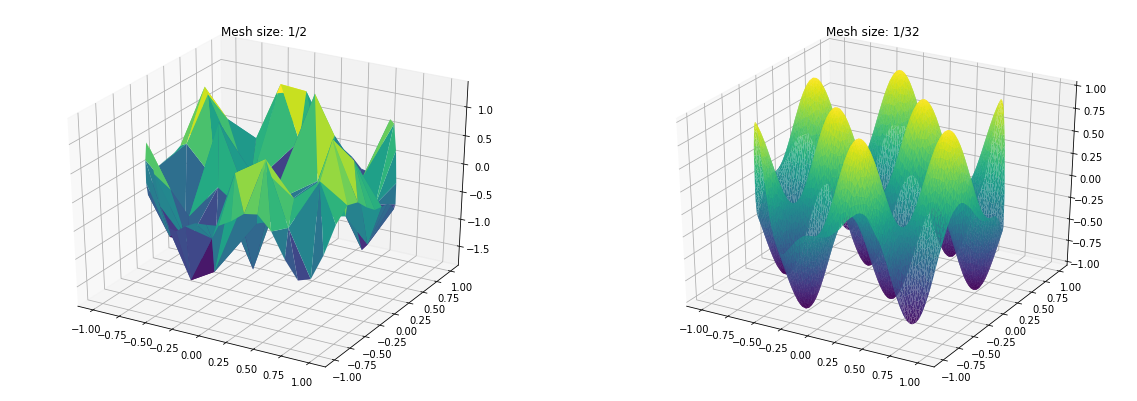

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(xs['u4'], ys['u4'], us['u4'], cmap='viridis')
ax.set_title('Mesh size: 1/2')
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(xs['u64'], ys['u64'], us['u64'], cmap='viridis')
ax.set_title('Mesh size: 1/32')
plt.savefig('imgs/B1.png')

# Problem B.2
The equations:
\begin{align}
\partial_t u(x,t) - \alpha \Delta u(x, t) &= f(x), \qquad (x, t) \in \mathscr{B} \times (0, T], \\
u(x, t) &= 0, \qquad (x, t) \in \partial \mathscr{B} \times (0, T], \\
u(x, 0) &= \begin{cases}
      \rho, & x \in \mathscr{T},\\
        0,    & x \in \mathscr{B} \setminus \mathscr{T},
    \end{cases} \qquad x \in \mathscr{B}
\end{align}

$\alpha$ is the diffusion coefficient and $\alpha = 0.01mm^2/day$. $f(x)$ is a given source function. $\mathscr{B}:={x \in \mathbb{R}^d: ||x|| \leq 1}$ is a unit disk (in the 2D case) of radius $1$ located at the origin of the space. The boundary $\partial \mathscr{B} = {x \in \mathbb{R}^d: ||x||=1}$. 

$\mathscr{T}$ denotes the torus with the major radius R and the minor radius r, r<R. The the 2D case:
$$ \mathscr{T} := 
|R-(x_1^2 + x_2^2)^\frac{1}{2}| \leq r, x \in \mathbb{R)^2} $$

## The Galerkin finite element method

Let $\partial_t u(x,t) = 0$, multiple both sizes with a test function $v \in V_0$, $V_0 = \{v \in V, v|_{\partial \mathscr{B}} = 0\}$ and integrate to obtain the weak form:  
\begin{align}
\int_\mathscr{B} fvdx 
&= - \int_\mathscr{B} \alpha \Delta u v dx \\
&= \int_\mathscr{B} \alpha \nabla u \nabla v dx - \int_\mathscr{B} \alpha n\cdot \nabla u v dx \\
&= \int_\mathscr{B} \alpha\nabla u \nabla v dx
\end{align}

We need to find $u \in V_0$, $V_0 = \{v \in V, V|_{\partial \mathscr{B}} = 0\}$, s.t the weak form is satisfied for $\forall v \in V_0$.

In the finite element function space, we need to find $u_h \in V_h$, $V_h = \{v \in V_h, V|_{\partial \mathscr{B}} = 0\}$, s.t.
$$ \int_\mathscr{B} \nabla u_h \nabla v dx = \int_\mathscr{B} fvdx$$
for $\forall v \in V_{h,0}$, $V_{h,0} = \{v \in V_h, V_h|_{\partial \mathscr{B}} = 0\}$,.

Ansatz: 
$$u_h = \sum_{j=1}^{n_h} \xi_j \phi_j$$
The first term are the interior points and the second term are the points on the boundary, $\xi_j = g_j$, in which $j=n_h+1, ..., n$.

$$\sum_{j=1}^{n_h} \xi_j \int_\mathscr{B} \phi_j'\phi_i' dx = \int_\mathscr{B} f \phi_i dx$$

Let 
$$A_{ij} =  \int_\mathscr{B} \phi_j'\phi_i' dx$$ 
$$b_i = \int_\mathscr{B} f \phi_i dx$$

The linear system for $\xi$ becomes:
$$\mathbf{A}\xi = \mathbf{b}$$

In the programming implementation, the $\mathbf{b}$ is set to be a zero vector because both $f(x)$ and $u|_{\partial \mathscr{B}}$ have zero values.

# Problem B.3

In [14]:
def u_initial(X, rho=10, R=0.5, r=0.3):
    '''
    Input X is a nx2 array, the corrinates of the n vertices
    Returns u(x, 0), the initial condition
    '''
    u0 = np.zeros(len(X))
    u0[np.where(np.abs(R-np.linalg.norm(X, axis=1)) <= r)] = rho
    return u0  


def f(x, y):
    return 0

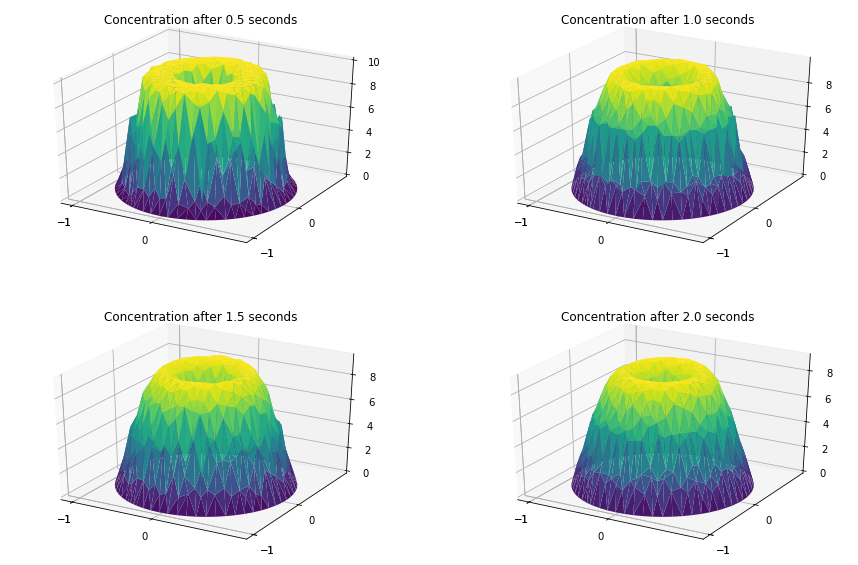

In [53]:
k = 0.5   # time step
T = 30    # final time

# Define domain
domain = Circle(Point(0.,0.),1.0,60)
mesh = generate_mesh(domain, 15, "cgal")

# Generating p-vertex coordinates, e-edge indices, t-element indices
p = mesh.coordinates()
e_points = BoundaryMesh(mesh, "exterior", True)
e_indices = e_points.entity_map(0)
e = e_indices.array()          # first column
e2 = np.append(e[1:], e[0])    # second column
e = np.dstack((e, e2)).squeeze()
t = mesh.cells()

x = p[:,0]
y = p[:,1]               # node coordinates
xi = u_initial(p)          # initial condition

A, M, b = assembler(p, t, f, alpha=0.01)

I = np.eye(len(p))

fig = plt.figure()

for l in range(round(T/k)): # time loop
    # Crank-Nicolson
    LHS = 2*M + k*A
    RHS = (2*M - k*A) * xi#+ 2*k*b    # b=0
    LHS[e[:,0],:] = I[e[:,0],:]
    RHS[e[:,0]] = 0
    xi= splinalg.spsolve(LHS.tocsr(), RHS.reshape(-1,1))
    
#    xi[e[:,0]] = 0          # set BC to zero for all boundary points, redundant
    
    if l<4:
        ax = fig.add_subplot(2, 2, l+1, projection='3d')
        ax.plot_trisurf(x, y, xi, cmap='viridis')
        ax.set_xticks([-1, 0, -1])
        ax.set_yticks([-1, 0, -1])
        ax.set_title('Concentration after %s seconds' %str(l/2+0.5))

#plt.savefig('imgs/concentration-2s.png')
plt.show()

### hmax = 1/5 and hmax = 1/20

In [12]:
# Integral of the element
def integral(g, p, x):
    '''
    Input g: function value at the vertices of the element
    Input p: point coordinates of the mesh
    Input x: indices of the tree vertices
    Output: The integral of g on an element
    '''
    K = polyArea(p[x][:,0], p[x][:,1])
    return K/3 * np.sum(g[x])

In [15]:
resolution = [10, 40]   # corresponds to hmax = 1/5 and hmax = 1/20
ms = {'r10':[], 'r40':[]}    # mass loss dictionary
keys2 = ['r10', 'r40']
hs2 = []

k = 0.2   # time step
T = 30    # final time

def f(x, y):
    return 0

for i in range(len(resolution)):
    
    m_loss = []
    
    # Define domain
    domain = Circle(Point(0.,0.),1.0,60)
    mesh = generate_mesh(domain, resolution[i], "cgal")

    # Generating p-vertex coordinates, e-edge indices, t-element indices
    p = mesh.coordinates()
    e_points = BoundaryMesh(mesh, "exterior", True)
    e_indices = e_points.entity_map(0)
    e = e_indices.array()          # first column
    e2 = np.append(e[1:], e[0])    # second column
    e = np.dstack((e, e2)).squeeze()
    t = mesh.cells()

    #n_p = np.shape(p)[0]     # number of nodes
    x = p[:,0]
    y = p[:,1]               # node coordinates
    hs2.append(mesh.hmax())
    xi = u_initial(p)          # initial condition
    c_start = np.sum([integral(xi, p, ti) for ti in t])    # Start mass

    A, M, b= assembler(p, t, f, alpha=0.01)
    I = np.eye(len(p))
    
    for l in range(round(T/k)): # time loop
        # Crank-Nicolson
        LHS = 2*M + k*A
        RHS = (2*M - k*A) * xi#+ 2*k*b    # b=0
        LHS[e[:,0],:] = I[e[:,0],:]
        RHS[e[:,0]] = 0
        xi= splinalg.spsolve(LHS.tocsr(), RHS.reshape(-1,1))

        xi[e[:,0]] = 0          # set BC to zero for all boundary points
        c = np.sum([integral(xi, p, ti) for ti in t])  # mass at the time point
        m_loss.append(c_start - c)      # mass loss at this time point
    
    ms[keys2[i]] = m_loss.copy()

/Users/CLee/miniconda3/envs/FEM/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


### Mass loss with h=1/5 and h=1/20

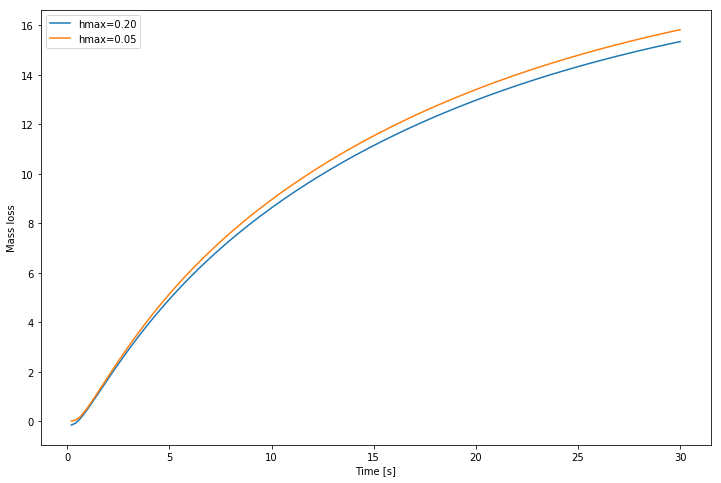

In [19]:
fig = plt.figure(figsize=(12, 8))
plt.plot(np.arange(k, T+k, k), ms['r10'], label="hmax=%1.2f"%hs2[0])
plt.plot(np.arange(k, T+k, k), ms['r40'], label="hmax=%1.2f"%hs2[1])
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Mass loss')
plt.savefig('imgs/massloss.png')

In [28]:
# Mass loss
xi0 = u_initial(p)
startConcentration = np.sum([integral(xi0, p, ti) for ti in t])      # summing up the function over the mesh of the initial condition
endConcentration = np.sum([integral(xi, p, ti) for ti in t])         # summing up the function over the mesh at the end
print('Mass loss: %f' % (startConcentration - endConcentration))

Mass loss: 15.823336


### Concentration at T=0s and T=30s. 

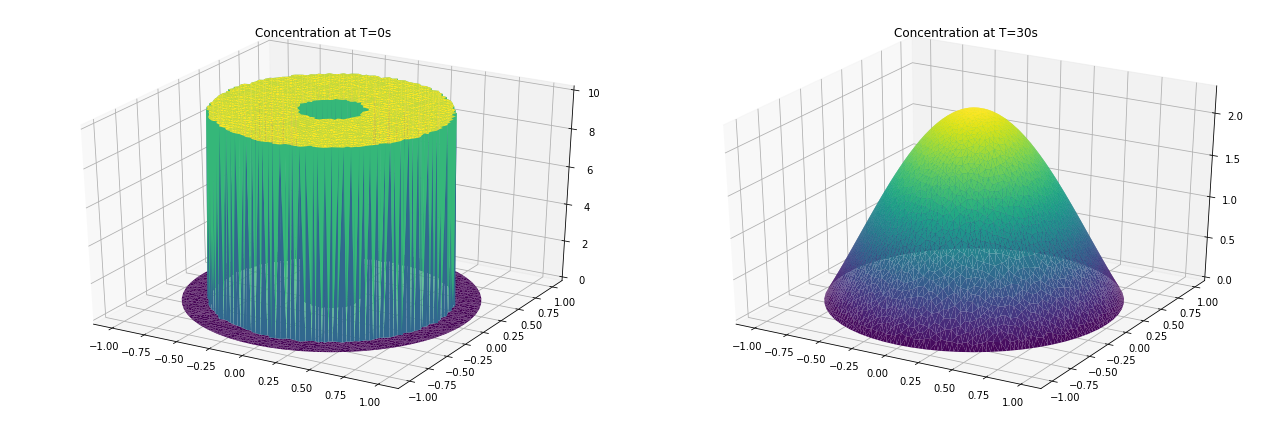

In [24]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(x, y, u_initial(p), cmap='viridis')
ax.set_title('Concentration at T=0s')
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(x, y, xi, cmap='viridis')
ax.set_title('Concentration at T=30s')
plt.savefig('imgs/Concentration_0-30_hmax005k02.png')

plt.tight_layout()
plt.show()